#  Tesina sugli open data riguardante i monumenti siciliani

*link ai dataset*

[Comuni italiani]("https://www4.istat.it/storage/codici-unita-amministrative/Elenco-comuni-italiani.csv")

[Castelli, fortezze  e Torri]("https://dati.regione.sicilia.it/catalogo/4e32671c-9f69-43d3-8093-240804cc93b1")

Questi dataset hanno la licenza CC-BY-4.0




## Pulizia e Arricchimento dei Dati

Nel processo di preparazione dei dati, ci siamo confrontati principalmente con colonne contenenti valori nulli o ridondanti. La pulizia dei dati è stata effettuata utilizzando principalmente OpenRefine con lo strumento text facet , con l'aggiunta di alcune modifiche effettuate tramite pandas:

- Correzione di un errore di denominazione da "Mazzara" a "Mazara".
- Integrazione dei codici ISTAT mancanti nei dataset relativi a castelli, fortezze e torri.
- Aggiunta di informazioni sui siti web relativi ai castelli.
- Rimozione del carattere "" per migliorare la leggibilità dei dataset.
- Modifica della denominazione della colonna "Località" in "Localita".
- Sostituzione di "Pa" con "PA".
- Completamento delle informazioni sulle fortezze.
- Selezione dei Comuni siciliano con codice istat e provincia
- Arrichimento di Fortezze fondendolo con il dataset dei comuni citato nel punto precedente

Con queste operazioni, i nostri file dati sono ora pronti per il prossimo passo: la costruzione dell'ontologia.

In [ ]:
import pandas as pd
from frictionless import validate
from frictionless import Resource
fortezze_csv = "C:\\Users\\harub\\Documents\\GitHub\\ProgettoOpenData2023\\dataset\\fortezze.csv"

torri_costiere_csv = "C:\\Users\\harub\\Documents\\GitHub\\ProgettoOpenData2023\\dataset\\torri.csv"
castelli_csv = "C:\\Users\\harub\\Documents\\GitHub\\ProgettoOpenData2023\\dataset\\castelli.csv"
comuni_csv= "C:\\Users\\harub\\Documents\\GitHub\\ProgettoOpenData2023\\dataset\\Elenco-comuni-italiani.csv"
#castelli = pd.read_csv(castelli_csv,sep = ";")
#print(castelli.head(10))

def capitalize_column_name(column_name):
    if column_name not in ['longitude', 'latitude','PRO_COM_T']:
        return column_name.capitalize()
    return column_name

def elimina_colonne(lista,dataframe):
    df = pd.read_csv(dataframe, sep=",")
    df.drop(columns=lista,inplace=True)
    return df



castelli_eliminare = ["Id","TIPO","SOTTO_TIPO","OBJECTID_1","OBJECTID","cons","data_caricamento"]

fortezze_eliminare = ["OBJECTID","Id","OBJECTID_1","data_caricamento"]

fortezze = elimina_colonne(fortezze_eliminare,fortezze_csv)

torri_eliminare = ["ID","OBJECTID","RIFMAZ","NUM","CONS","OBJECTID_12","OBJECTID_1","data_caricamento"]

torri_costiere = elimina_colonne(torri_eliminare,torri_costiere_csv)

castelli = elimina_colonne(castelli_eliminare,castelli_csv)

castelli.rename(columns={'DENOMINAZI':'DENOMINAZIONE'},inplace= True)
fortezze.rename(columns={'Denom':'Denominazione'},inplace= True)
torri_costiere.rename(columns={'DENOM':'Denominazione'},inplace= True)

lista_colonne_c = castelli.columns.tolist()
lista_colonne_t = torri_costiere.columns.tolist()
castelli = castelli.rename(columns={col: capitalize_column_name(col) for col in lista_colonne_c})
torri_costiere = torri_costiere.rename(columns={col: capitalize_column_name(col) for col in lista_colonne_t})


comuni = pd.read_csv(comuni_csv,sep =",")
#print(comuni.columns)
#Prendo solo i comuni appartenenti alla regione Sicilia che ha codice regione 19
comuni = comuni[comuni['Codice Regione'] == 19]

# Seleziona solo le colonne desiderate
columns_to_keep = ['Denominazione in italiano', 'Sigla automobilistica', 'Codice Comune formato numerico']
comuni = comuni[columns_to_keep]
comuni.rename(columns={'Denominazione in italiano':'Comune'},inplace= True)
comuni.rename(columns={'Sigla automobilistica':'Provincia'},inplace= True)
comuni.rename(columns={'Codice Comune formato numerico':'Codice_Istat'},inplace= True)

fortezze = fortezze.merge(comuni, left_on='PRO_COM_T', right_on='Codice_Istat', how='left')
fortezze = fortezze.drop(['Codice_Istat'],axis=1)

fortezze["Provincia"] = fortezze["Provincia"].replace("Pa","PA")
castelli["Prov"] = castelli["Prov"].replace("Pa","PA")
torri_costiere["Provincia"] = torri_costiere["Provincia"].replace("Pa","PA")
comuni["Provincia"]= comuni["Provincia"].replace("Pa","PA")

castelli.to_csv("C:\\Users\\harub\\Documents\\GitHub\\ProgettoOpenData2023\\dataset_finali\\dataset_csv\\castelli.csv", index=False)
fortezze.to_csv("C:\\Users\\harub\\Documents\\GitHub\\ProgettoOpenData2023\\dataset_finali\\dataset_csv\\fortezze.csv", index=False)
torri_costiere.to_csv("C:\\Users\\harub\\Documents\\GitHub\\ProgettoOpenData2023\\dataset_finali\\dataset_csv\\torri.csv",index=False,)
comuni.to_csv("C:\\Users\\harub\\Documents\\GitHub\\ProgettoOpenData2023\\dataset_finali\\dataset_csv\\comuni.csv", index=False)

## Costruzione dell’Ontologia

L'ontologia è stata progettata in modo da comprendere due classi principali: "Monumento Storico" e "Comune". "Monumento Storico" è una superclasse che contiene tutti gli attributi comuni delle sottoclassi, riguardanti torri, castelli e fortezze. È stata definita la proprietà "IsIn" per stabilire che un "Monumento Storico" si trova all'interno di un "Comune".

Alcune proprietà di MonumentoStorico:

haDenominazione,haComune ,haProvincia ,haLat, haLong

Proprietà per Comuni: haNome, haSiglaProvincia, haCodiceIstat

Castelli,Torri e Fortezze hanno attributi quali haCronologia, oppure Lunghezza del raggio del faro oppure haLocStorica appartenti a torri 

L’uri riguardante l’ontologia è: 

`'http://www.turismosicilia.org/ontology.'`

Mentre le sue risorse sono: 

`('http://www.turismosicilia.org/resource.`
I


Per il passaggio dei dataset da 3 a 5 stelle ci si è basati sullo standard RDF di W3C, congiunta con la libreria `rdflib` di Python.

Il primo step è stata l'inizializzazione del grafo RDF e dei namespace di interesse.
Per identificare le risorse, a partire dall'URI di base "http://www.turismosicilia.it/resource/" si sono fatte le seguenti scelte:
- per i comuni si è scelto il nome come identificativo, togliendo da essa apostrofi e spazi; 
- per le risorse rimanenti si è scelti la denominazione 

Per ogni colonna di ogni dataset si aggiunge al grafo una tripla, facendo riferimento all'omonima proprietà definita nell'ontologia.

Per quanto riguarda l'interlinking viene sfruttata la base di conoscenza dbpedia.org. Dapprima, attraverso una query SPARQL, per ogni comune si crea un collegamento con l'omonima risorsa presente su dbpedia.
 
infine si serializza il grafo in due formati xml e ttl


In [ ]:
import csv
import urllib.parse
import math
import pandas as pd
import requests
from rdflib import Graph, Literal, Namespace, URIRef, BNode
from rdflib.namespace import RDF, OWL, XSD
from SPARQLWrapper import SPARQLWrapper, JSON


g = Graph()
ts = Namespace('http://www.turismosicilia.org/ontology/')
base_uri = "http://www.turismosicilia.org/resource/"
g.bind("ts",ts)

castelli_csv =r"C:\Users\harub\Documents\GitHub\ProgettoOpenData2023\dataset_finali\dataset_csv\castelli.csv"
comuni_csv=r"C:\Users\harub\Documents\GitHub\ProgettoOpenData2023\dataset_finali\dataset_csv\comuni.csv"
fortezze_csv = r"C:\Users\harub\Documents\GitHub\ProgettoOpenData2023\dataset_finali\dataset_csv\fortezze.csv"
torri_csv = r"C:\Users\harub\Documents\GitHub\ProgettoOpenData2023\dataset_finali\dataset_csv\torri.csv"

comuni_df = pd.read_csv(comuni_csv)
castelli_df = pd.read_csv(castelli_csv)
fortezze_df = pd.read_csv(fortezze_csv)
torri_df = pd.read_csv(torri_csv)

def urify(base, name):
    name = name.replace(" ", "_").replace(".", "")
    return base + urllib.parse.quote(name)
def interlinkDbpediaComune(comune_uri, nome):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setTimeout(10000)
    query = f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX dbr: <http://dbpedia.org/resource/>
            SELECT ?label ?link
            WHERE {{
              ?comune a dbo:Settlement ;
                      dbo:region dbr:Sicily ;
                      rdfs:label ?label ;
                      owl:sameAs ?link .
              FILTER(LANG(?label) = "it") .
            }}
        """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    bindings = results["results"]["bindings"]
def add_comuni(row):
    comune_uri = URIRef(urify(base_uri, row['Comune']))
    g.add((comune_uri, URIRef(RDF.type), URIRef(ts.Comuni)))
    g.add((comune_uri, ts.haNome, Literal(row['Comune'], datatype=XSD.string)))
    g.add((comune_uri, ts.haSiglaProvincia, Literal(row['Provincia'], datatype=XSD.string)))
    g.add((comune_uri, ts.haCodiceIstat, Literal(row['Codice_Istat'], datatype=XSD.string)))
    interlinkDbpediaComune(comune_uri, row['Comune'])

def add_castelli(row):
    for_comune = URIRef(urify(base_uri, row['Comune']))
    castello_uri = URIRef(urify(base_uri, row['Denominazione']))
    g.add((castello_uri, URIRef(RDF.type), URIRef(ts.Castelli)))
    g.add((castello_uri, ts.haDenominazione, Literal(row['Denominazione'], datatype=XSD.string)))
    g.add((castello_uri, ts.haProvincia, Literal(row['Prov'], datatype=XSD.string)))
    g.add((castello_uri, ts.haCronologia, Literal(row['Cronologia'], datatype=XSD.string)))
    g.add((castello_uri, ts.haGestoreT, Literal(row['Prop_att'], datatype=XSD.string)))
    g.add((castello_uri, ts.haUso, Literal(row['Uso_att'], datatype=XSD.string)))
    g.add((castello_uri, ts.haSitoWeb, Literal(row['Web_link'], datatype=XSD.anyURI)))
    g.add((castello_uri, ts.haImmagine, Literal(row['Image_link'], datatype=XSD.anyURI)))
    g.add((castello_uri, ts.haNote, Literal(row['Note_1'], datatype=XSD.string)))
    g.add((castello_uri, ts.haLongitudine, Literal(row['longitude'], datatype=XSD.double)))
    g.add((castello_uri, ts.haLatitudine, Literal(row['latitude'], datatype=XSD.double)))
    g.add((castello_uri, ts.haComune, Literal(row['Comune'], datatype=XSD.string)))
    g.add((for_comune, ts.haNome, Literal(row['Comune'], datatype=XSD.string)))
    g.add((castello_uri, ts.isIn, for_comune))

def add_fortezze(row):
    for_comune = URIRef(urify(base_uri, row['Comune']))
    fortezza_uri = URIRef(urify(base_uri, row['Denominazione']))
    g.add((fortezza_uri, URIRef(RDF.type), URIRef(ts.Fortezze)))
    g.add((fortezza_uri, ts.haDenominazione, Literal(row['Denominazione'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.haCronologiaF, Literal(row['Cronologia'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.haS_L_M, Literal(row['s_l_m_'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.haUbicazione, Literal(row['Ubicazione'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.haStatoConservazione, Literal(row['Stato_Cons'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.haGestore, Literal(row['Gestore'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.haIconaTorri, Literal(row['ico_image'], datatype=XSD.anyURI)))
    g.add((fortezza_uri, ts.haUso, Literal(row['Uso'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.haSitoWeb, Literal(row['weblink'], datatype=XSD.anyURI)))
    g.add((fortezza_uri, ts.haTipologia, Literal(row['Tipologia'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.haNote, Literal(row['note_'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.haLongitudine, Literal(row['longitude'], datatype=XSD.double)))
    g.add((fortezza_uri, ts.haLatitudine, Literal(row['latitude'], datatype=XSD.double)))
    g.add((fortezza_uri, ts.haProvincia, Literal(row['Provincia'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.haComune, Literal(row['Comune'], datatype=XSD.string)))
    g.add((for_comune, ts.haNome, Literal(row['Comune'], datatype=XSD.string)))
    g.add((fortezza_uri, ts.isIn, for_comune))

def add_torri(row):
    for_comune = URIRef(urify(base_uri, row['Comune']))
    torre_uri = URIRef(urify(base_uri, row['Denominazione']))
    g.add((torre_uri, URIRef(RDF.type), URIRef(ts.TorriCostiere)))
    g.add((torre_uri, ts.haDenominazione, Literal(row['Denominazione'], datatype=XSD.string)))
    g.add((torre_uri, ts.haTipo, Literal(row['Tipo'], datatype=XSD.string)))
    g.add((torre_uri, ts.haGestoreT, Literal(row['Amstor'], datatype=XSD.string)))
    g.add((torre_uri, ts.haNote, Literal(row['Note2'], datatype=XSD.string)))
    g.add((torre_uri, ts.haLocazioneStorica, Literal(row['Loc_stor'], datatype=XSD.string)))
    g.add((torre_uri, ts.haSitoWeb, Literal(row['Foto_web'], datatype=XSD.anyURI)))
    g.add((torre_uri, ts.haConservazione, Literal(row['Consit'], datatype=XSD.string)))
    g.add((torre_uri, ts.haStatoProprietario, Literal(row['Proat'], datatype=XSD.string)))
    g.add((torre_uri, ts.haIconaTorri, Literal(row['Ico_torri'], datatype=XSD.anyURI)))
    g.add((torre_uri, ts.haLocalita, Literal(row['Localita'], datatype=XSD.string)))
    g.add((torre_uri, ts.haLatitudine, Literal(row['latitude'], datatype=XSD.double)))
    g.add((torre_uri, ts.haLongitudine, Literal(row['longitude'], datatype=XSD.double)))
    g.add((torre_uri, ts.haLonge, Literal(row['Longe'], datatype=XSD.double)))
    g.add((torre_uri, ts.haProvincia, Literal(row['Provincia'],datatype=XSD.string)))
    g.add((torre_uri, ts.haComune, Literal(row['Comune'], datatype=XSD.string)))
    g.add((for_comune, ts.haNome, Literal(row['Comune'], datatype=XSD.string)))
    g.add((torre_uri, ts.isIn, for_comune))

# Apply the functions to the respective DataFrames

comuni_df['Comune'] = comuni_df['Comune'].astype(str)
comuni_df.apply(add_comuni, axis=1)

castelli_df['Denominazione'] = castelli_df['Denominazione'].astype(str)
castelli_df['Note_1'] = castelli_df['Note_1'].astype(str)
castelli_df.apply(add_castelli, axis=1)

#fortezze_df['Denominazione'] = fortezze_df['Denominazione'].astype(str)
fortezze_df['note_'] = fortezze_df['note_'].astype(str)
fortezze_df.apply(add_fortezze, axis=1)

torri_df['Denominazione'] = torri_df['Denominazione'].astype(str)
torri_df['Note2'] = torri_df['Note2'].astype(str)
torri_df.apply(add_torri, axis=1)

g.serialize(destination="C:\\Users\\harub\\Documents\\GitHub\\ProgettoOpenData2023\\dataset_completi\\datasetFinale_ttl.ttl",format= 'turtle')
g.serialize(destination="C:\\Users\\harub\\Documents\\GitHub\\ProgettoOpenData2023\\dataset_completi\\datasetFinale_XML.xml", format="xml")


## Rappresentazione Grafica

Partendo dai dati puliti, abbiamo deciso di creare due tipi di grafici:

1. **Distribuzione di Castelli, Torri e Fortezze per Provincia**

Questo grafico offre una panoramica chiara della distribuzione di queste strutture storiche in base alle province.

2. **Città con il Maggior Numero di Monumenti**

Questo grafico evidenzia le città che ospitano il maggior numero di monumenti storici, permettendoci di identificare le località più ricche di patrimonio culturale.

# Monumenti Per provincia

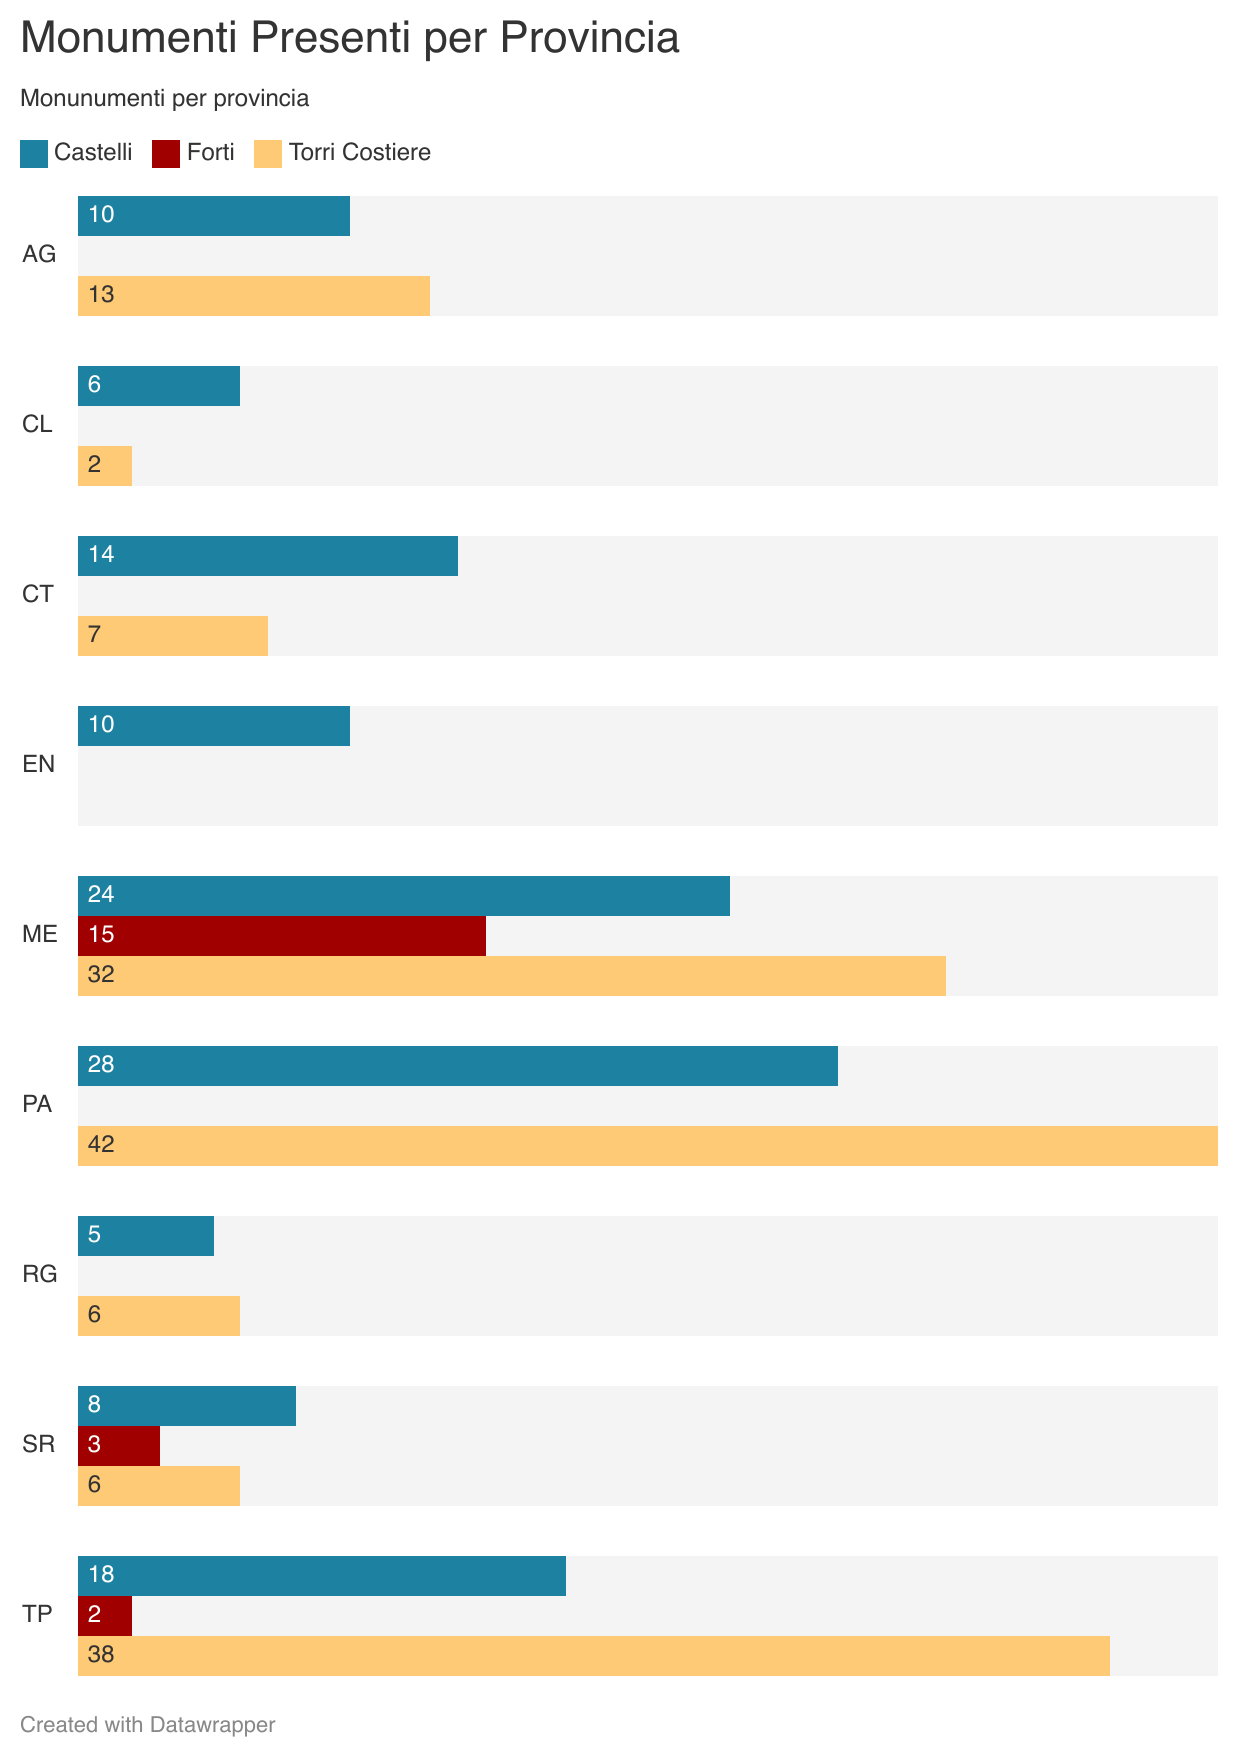

In [10]:
from PIL import Image
from IPython.display import display

img = Image.open(r'C:\Users\harub\Documents\GitHub\ProgettoOpenData2023\Progetto_Open_data\monumenti-presenti-per-provincia.png')
display(img)

# Citta con più monumenti

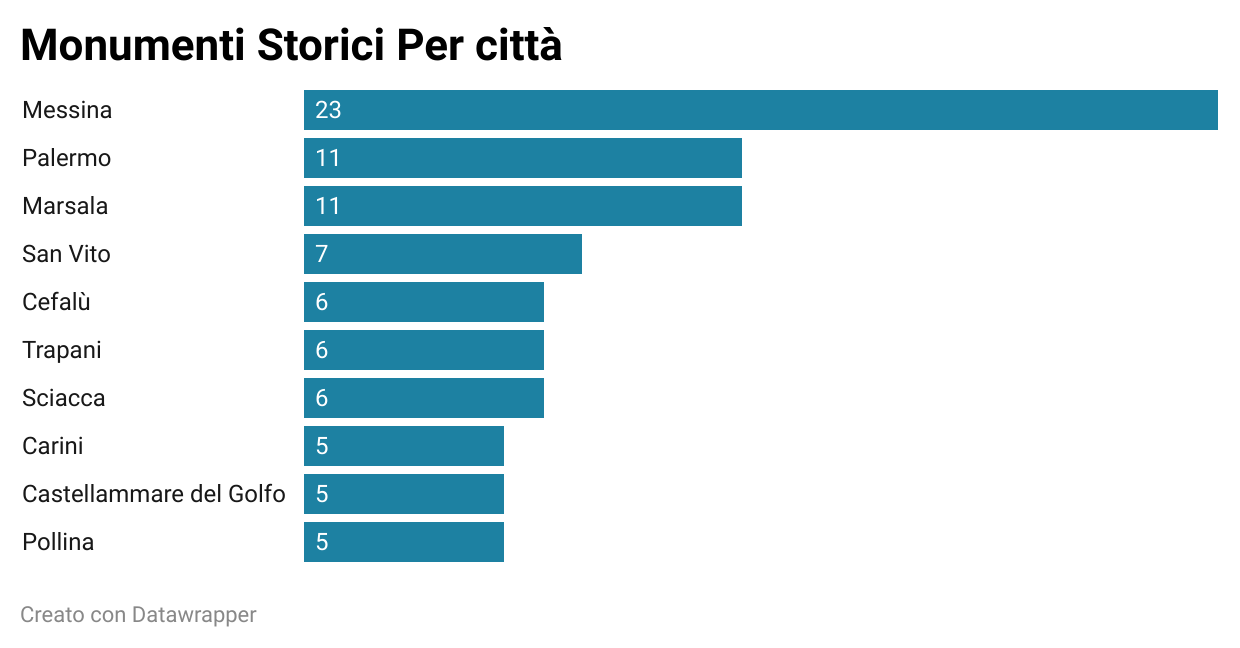

In [11]:
from PIL import Image
from IPython.display import display

img = Image.open(r'C:\Users\harub\Documents\GitHub\ProgettoOpenData2023\Progetto_Open_data\monumenti-storici-per-citt-.png')
display(img)


# Città nel dettaglio

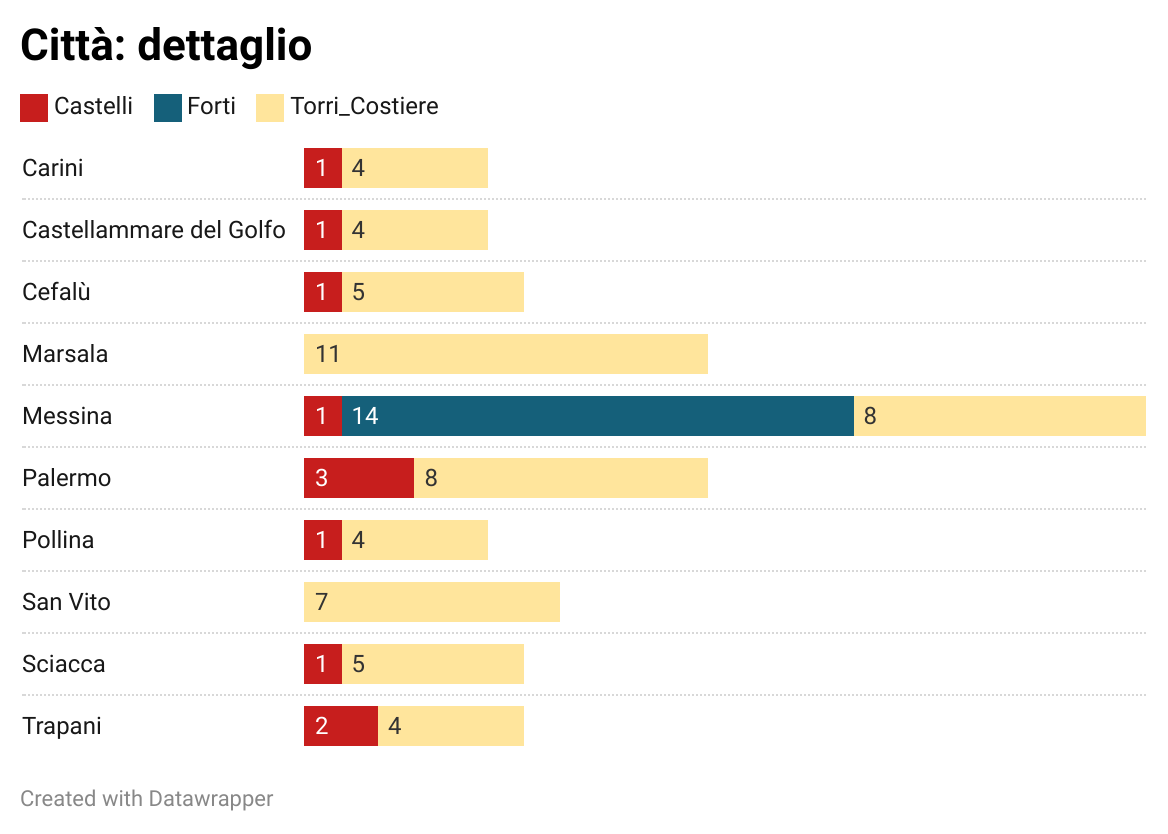

In [12]:
from IPython.display import display

img = Image.open(r'C:\Users\harub\Documents\GitHub\ProgettoOpenData2023\Progetto_Open_data\citt-dettaglio.png')
display(img)

Si noti che nelle citta con più monumenti ci sono pochi castelli,ma tantissime torre costiere, in evidenza la citta di marsala ha solo torri costiere, ovviamente i dataset non sono completi, di 23 forti presenti nel dataset si nota che 14 di essi appartengono a messina, mentre palermo è quella con più castelli